In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import json

In [2]:
# Drawing helper functions

def show_image(im, convert_color=True):
    if convert_color:
        rgb_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    else:
        rgb_im = im.copy()
    plt.imshow(rgb_im)
    plt.show()

def draw_circles(im, circles, color):
    if circles is not None:
        circ_arr = np.uint16(np.around(circles))
        for x, y, r in circ_arr[0, :]:
            cv2.circle(im, (x, y), r, color, 3)

In [3]:
with open("./extracted_headstamps/detections.json") as f:
    data = json.load(f)

In [108]:
data["all_detections"][-1]["detections"][0]["casing"]["box"]

[0.5311511993408203,
 0.2127499875769151,
 0.9718384878976004,
 0.9205391582837851]

In [4]:
images = []
for d in data["all_detections"]:
    file_name = d["filename"].split("/")[-1]
    
    for indexer, detection in enumerate(d["detections"]):
        image_file_name = file_name + f"_{indexer}.png"
        casing_box = np.array(detection["casing"]["box"])
        primer_box = np.array(detection["primer"]["box"])
        images.append([image_file_name, casing_box, primer_box])
    

<class 'numpy.ndarray'>


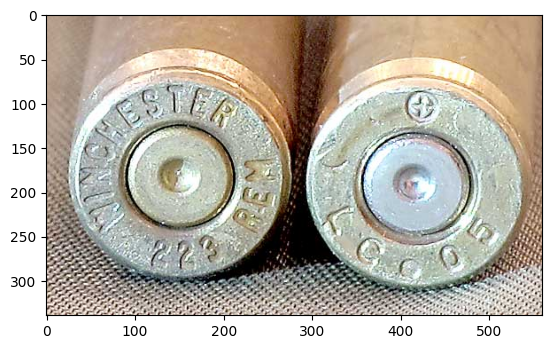

In [14]:
img = cv2.imread(f"./extracted_headstamps/{images[4][0]}")
print(type(img))
show_image(img)

In [15]:
"""
{"detections": 
    [{"casing": {"confidence": 0.9991961121559143, 
                 "box": [0.038091355782968024, 0.06166147264615973, 0.9618090594256365, 0.935266979728212]}, 
      "primer": {"confidence": 0.9967407584190369, 
                 "box": [0.2849817911783854, 0.30220863911233714, 0.7208954987702546, 0.6978002995493598]}}], 
"inference_version": "1.0", "filename": "/mnt/c/GitHub/CartridgeOCR/data/dataset_deduped/17 88 image A1.jpg"}
"""

casing_box = images[4][1]
primer_box = images[4][2]

In [16]:
print(casing_box[::2] * img.shape[0], casing_box[1::2] * img.shape[1])

[180.06025658 329.4532474 ] [119.13999304 515.50192864]


In [22]:
casing_tl_x, casing_br_x = np.round((casing_box[::2] * img.shape[1])).astype("int")
casing_tl_y, casing_br_y = np.round((casing_box[1::2] * img.shape[0])).astype("int")

casing_mid_x = casing_tl_x + (casing_br_x - casing_tl_x) / 2 
casing_mid_y = casing_tl_y + (casing_br_y - casing_tl_y) / 2
casing_radius = int(max((casing_br_x - casing_tl_x) / 2, (casing_br_y - casing_tl_y) / 2))
casing_midpoints = np.array([[casing_tl_x, casing_mid_y], [casing_mid_x, casing_tl_y], [casing_br_x, casing_mid_y], [casing_mid_x, casing_br_y], [casing_mid_x, casing_mid_y]]).astype('int')

print((casing_mid_x, casing_mid_y))

primer_tl_x, primer_br_x = (primer_box[::2] * img.shape[1]).astype("int")
primer_tl_y, primer_br_y = (primer_box[1::2] * img.shape[0]).astype("int")

primer_mid_x = primer_tl_x + (primer_br_x - primer_tl_x) / 2
primer_mid_y = primer_tl_y + (primer_br_y - primer_tl_y) / 2
primer_radius = int(max((primer_br_x - primer_tl_x) / 2, (primer_br_y - primer_tl_y) / 2))
primer_midpoints = np.array([[primer_tl_x, primer_mid_y], [primer_mid_x, primer_tl_y], [primer_br_x, casing_mid_y], [primer_mid_y, primer_br_y], [primer_mid_x, primer_mid_y]]).astype('int')


(420.5, 192.0)


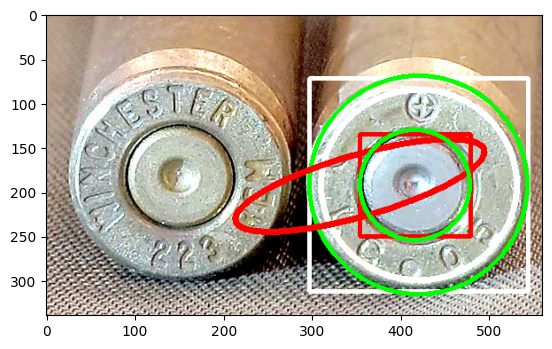

In [23]:
output = img.copy()

cv2.rectangle(output,(casing_tl_x, casing_tl_y), (casing_br_x, casing_br_y), (255, 255, 255), 3)

casing_ellipse = cv2.fitEllipseDirect(casing_midpoints)
cv2.ellipse(output, casing_ellipse, (255, 255, 255), 5)
cv2.circle(output, (int(casing_mid_x), int(casing_mid_y)), casing_radius, (0, 255, 0), 3)

cv2.rectangle(output,(primer_tl_x, primer_tl_y), (primer_br_x, primer_br_y), (0, 0, 255), 3)

primer_ellipse = cv2.fitEllipseDirect(primer_midpoints)
cv2.ellipse(output, primer_ellipse, (0, 0, 255), 5)
cv2.circle(output, (int(primer_mid_x), int(primer_mid_y)), primer_radius, (0, 255, 0), 3)

show_image(output)

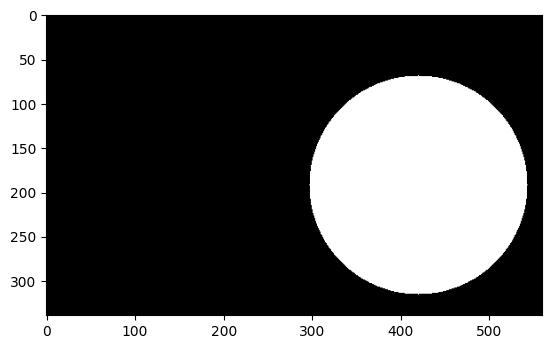

In [24]:
casing_mask = np.zeros(img.shape).astype('uint8')
cv2.circle(casing_mask, (int(casing_mid_x), int(casing_mid_y)), casing_radius, (255, 255, 255), -1)
show_image(casing_mask, convert_color=False)

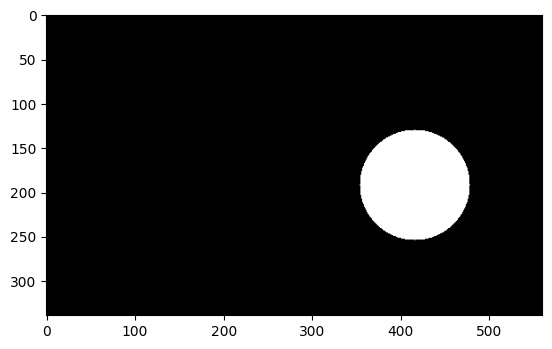

In [25]:
primer_mask = np.zeros(img.shape).astype('uint8')
cv2.circle(primer_mask, (int(primer_mid_x), int(primer_mid_y)), primer_radius, (255, 255, 255), -1)
show_image(primer_mask, convert_color=False)

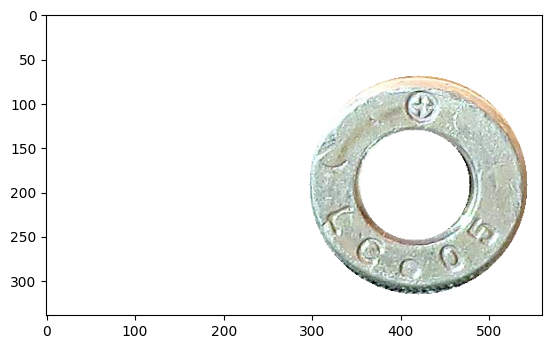

In [26]:
masked_img = img.copy()
headstamp_mask = cv2.subtract(casing_mask, primer_mask)
masked_img[headstamp_mask != 255] = 255

show_image(masked_img)